#Imports

In [ ]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs
 
 
# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
# from  tensorflow.keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
 
# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
#INITIAL PREPROCESSING
import argparse
import numpy as np
import os
import pandas as pd
from glob import glob
import h5py
# from loguru import logger
from tqdm import tqdm
from gensim.models.fasttext import FastText, FastTextKeyedVectors
from gensim.models.word2vec import Word2Vec
from gensim.utils import tokenize
 
sns.set_style("whitegrid")
np.random.seed(0)
 
MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lia first version of dataset pre-processing

In [ ]:
def read_files(transcriptdir,labels):
  train_df = pd.DataFrame()
  val_df=pd.DataFrame()
  for i in range(len(transcriptdir)):
    path=""
    path += transcriptdir[i]  
    files=glob(os.path.join(path)+"/*.csv")
    for filename in files:
      temp_df =pd.read_csv(filename,dtype=str, sep='\t', engine='python')
      head, tail = os.path.split(filename)
      speaker_id=tail[0:3]
      temp_df['Participant_ID'] = speaker_id
      temp_df.dropna(inplace=True)
      temp_df.drop(temp_df.loc[temp_df['speaker']=='Ellie'].index, inplace=True)
      temp_df=temp_df.drop(['start_time','stop_time'], axis = 1)
      temp_df['value'] = temp_df.groupby(['Participant_ID'])['value'].transform(lambda x : '.'.join(x))
      temp_df=temp_df.drop(temp_df.index[1:len(temp_df.index)])
      if os.path.basename(os.path.normpath(path))=='Train':
        train_df=train_df.append(temp_df)
      else:
        val_df=val_df.append(temp_df)
    if os.path.basename(os.path.normpath(path))=='Train':
      train_df['Participant_ID']=train_df['Participant_ID'].astype(int)
      labels_df_train = pd.read_csv(labels[i], engine='python')
      train_df = train_df.merge(labels_df_train, on="Participant_ID", how = 'inner')
      train_df.reset_index(drop=True)
      train_df['word_count'] = train_df['value'].str.findall(r'(\w+)').str.len()
    else:
      val_df['Participant_ID']=val_df['Participant_ID'].astype(int)
      labels_df_val = pd.read_csv(labels[i], engine='python')
      val_df = val_df.merge(labels_df_val, on="Participant_ID", how = 'inner')
      val_df.reset_index(drop=True)
      val_df['word_count'] = val_df['value'].str.findall(r'(\w+)').str.len()
  return train_df,val_df

In [ ]:
transcriptdir_list=['/content/drive/MyDrive/DepressionDataset/Train/','/content/drive/MyDrive/DepressionDataset/Dev/']
labels_path=['/content/drive/MyDrive/DepressionLabels/train_split_Depression_AVEC2017.csv','/content/drive/MyDrive/DepressionLabels/dev_split_Depression_AVEC2017.csv']
#train
train_df,val_df=read_files(transcriptdir_list,labels_path)

In [ ]:
train_df['value'] = train_df['value'].astype('string')
val_df['value'] = val_df['value'].astype('string')
train_arr = train_df["value"].to_numpy()
val_arr = val_df["value"].to_numpy()

##lower casing


In [ ]:
#lower casing
train_df['value'] = train_df['value'].str.lower()
val_df['value'] = val_df['value'].str.lower()

## custom pre processing 

In [ ]:
# overwriting column with replaced value of age 
def custom_prep(train_df):

  train_df["value"]= train_df["value"].str.replace("l_a", "los angeles", case = False)
  train_df["value"]= train_df["value"].str.replace("yeah", "yes", case = False)

  # MINE
  train_df["value"]= train_df["value"].str.replace("granddaugh", "granddaughter", case = False)
  train_df["value"]= train_df["value"].str.replace("screeenplay", "screenplay", case = False)
  train_df["value"]= train_df["value"].str.replace("botther", "bother", case = False)
  train_df["value"]= train_df["value"].str.replace("wholeso", "whole so", case = False)
  train_df["value"]= train_df["value"].str.replace("loiusiana", " ", case = False)
  train_df["value"]= train_df["value"].str.replace("stepsist", "stepsister", case = False)
  train_df["value"]= train_df["value"].str.replace("stockbrokage", "stock brokage", case = False)
  train_df["value"]= train_df["value"].str.replace("outburste", "outburst", case = False)
  train_df["value"]= train_df["value"].str.replace("undeserve", "do not deserve", case = False)
  train_df["value"]= train_df["value"].str.replace("sleepland", "sleep land", case = False)
  train_df["value"]= train_df["value"].str.replace("kickboxe", "kickbox", case = False)
  train_df["value"]= train_df["value"].str.replace("unemploye", "unemployed", case = False)
  train_df["value"]= train_df["value"].str.replace("wyome", " ", case = False)
  train_df["value"]= train_df["value"].str.replace("airheade", "airheaded", case = False)
  train_df["value"]= train_df["value"].str.replace("laguhter", "laughter", case = False)
  return train_df

train_df= custom_prep(train_df)
val_df=custom_prep(val_df)

In [ ]:
train_df["value"]

0      <synch>.yes.i'm good how are you.uh i was born...
1      <synch>.<sniffle>.<sniffle>.yes.i'm feeling ok...
2      <synch>.<sniffle>.yes i'm okay with it.um i'm ...
3      yes.fine thank you.montreal canada.i moved her...
4      <synch>.sure.good.indiana.um the weather i lik...
                             ...                        
102    yes .uh i'm okay a little sleepy right now .i'...
103    <sync>.yes.i'm good thank you.um i was born in...
104    [syncing].yes.i'm a little nervous.mm this is ...
105    yes .i'm doing pretty good <laughter> .i'm fro...
106    <synch>.yes.i'm good.michigan.two years ago.um...
Name: value, Length: 107, dtype: string

In [ ]:
import re
ids = train_df.value.str.contains('< >', flags = re.IGNORECASE, regex = True, na = False)
x=re.findall(r"[\w']+|[<>]", train_df["value"].iloc[0])

In [ ]:
train_df[ids]

,speaker,value,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving,word_count


##Removal of Punctuations

In [ ]:
#Removal of Punctuations
import re
def clean_punctuation(text):
  return re.sub(r'[^A-Za-z]+', ' ', text)
train_df['value']=train_df['value'].apply(clean_punctuation)
val_df['value']=val_df['value'].apply(clean_punctuation)

##Removal of stopwords


In [ ]:
#Removal of stopwords
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = stopwords.words('english')
custom_stop_word_list=['xxx','synch']
final_stopword_list = custom_stop_word_list + STOPWORDS
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in final_stopword_list])

train_df['value']= train_df['value'].apply(lambda text: remove_stopwords(text))
val_df['value']= val_df['value'].apply(lambda text: remove_stopwords(text))

## count and remove the most frequent words

In [ ]:
#count the most frequent words
from collections import Counter
cnt = Counter()
for text in train_df['value'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(5900)

[('um', 3535),
 ('uh', 2914),
 ('know', 2105),
 ('like', 2031),
 ('yes', 1029),
 ('really', 957),
 ('laughter', 882),
 ('good', 659),
 ('think', 653),
 ('people', 633),
 ('well', 579),
 ('things', 555),
 ('would', 542),
 ('get', 512),
 ('time', 491),
 ('lot', 462),
 ('go', 442),
 ('pretty', 440),
 ('one', 371),
 ('probably', 357),
 ('sigh', 339),
 ('little', 339),
 ('say', 333),
 ('life', 318),
 ('much', 311),
 ('kinda', 307),
 ('something', 300),
 ('feel', 300),
 ('mm', 296),
 ('guess', 292),
 ('years', 276),
 ('could', 273),
 ('different', 270),
 ('see', 267),
 ('going', 265),
 ('always', 243),
 ('hard', 237),
 ('back', 235),
 ('oh', 234),
 ('sometimes', 234),
 ('right', 231),
 ('mean', 225),
 ('went', 224),
 ('got', 222),
 ('family', 216),
 ('ago', 211),
 ('okay', 208),
 ('school', 208),
 ('kind', 204),
 ('love', 200),
 ('cause', 200),
 ('try', 199),
 ('maybe', 199),
 ('work', 188),
 ('day', 187),
 ('make', 185),
 ('friends', 183),
 ('last', 183),
 ('happy', 182),
 ('thing', 181),
 

In [ ]:
len(cnt)

5954

In [ ]:
#display the most rare words
cnt.most_common()[:-1000:-1]

[('addiction', 1),
 ('weigh', 1),
 ('headaches', 1),
 ('casting', 1),
 ('administrative', 1),
 ('duty', 1),
 ('skype', 1),
 ('clo', 1),
 ('prevented', 1),
 ('belt', 1),
 ('cheated', 1),
 ('sticking', 1),
 ('mcdonalds', 1),
 ('snuck', 1),
 ('cheat', 1),
 ('cop', 1),
 ('pastors', 1),
 ('blurt', 1),
 ('kickboxing', 1),
 ('frustration', 1),
 ('box', 1),
 ('musically', 1),
 ('jet', 1),
 ('hawa', 1),
 ('complexes', 1),
 ('houses', 1),
 ('properties', 1),
 ('credits', 1),
 ('ruder', 1),
 ('paced', 1),
 ('believing', 1),
 ('dreaming', 1),
 ('conformist', 1),
 ('daring', 1),
 ('fog', 1),
 ('jog', 1),
 ('causes', 1),
 ('hermit', 1),
 ('relieved', 1),
 ('ends', 1),
 ('formally', 1),
 ('terrain', 1),
 ('branch', 1),
 ('beliefs', 1),
 ('bubble', 1),
 ('absorbed', 1),
 ('norwegian', 1),
 ('nowadays', 1),
 ('freefalling', 1),
 ('uganda', 1),
 ('river', 1),
 ('nile', 1),
 ('bungee', 1),
 ('unselfish', 1),
 ('including', 1),
 ('deceived', 1),
 ('mistreated', 1),
 ('sunset', 1),
 ('realm', 1),
 ('misund

In [ ]:
cnt.most_common(2)

[('um', 3535), ('uh', 2914)]

In [ ]:
#remove the most frequent words
FREQWORDS = set([w for (w, wc) in cnt.most_common(2)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

train_df['value']= train_df['value'].apply(lambda text: remove_freqwords(text))
val_df['value']= val_df['value'].apply(lambda text: remove_freqwords(text))
train_df.head()

,speaker,value,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving,word_count
0,Participant,yes good born hawaii grew colorado yes yes sev...,474,0,4,1,0,0,2.0,1,0,1,0,0,1809
1,Participant,sniffle sniffle yes feeling okay little bit ti...,379,0,2,1,0,0,1.0,1,0,0,0,0,2664
2,Participant,sniffle yes okay okay okay guess scrubbed entr...,368,0,7,1,1,0,1.0,0,2,1,1,1,3707
3,Participant,yes fine thank montreal canada moved mom high ...,327,0,4,0,0,0,1.0,2,0,0,1,0,832
4,Participant,sure good indiana weather like weather never w...,443,0,1,1,1,0,0.0,0,0,0,0,0,551


## remove the most rare words

In [ ]:
#remove the most rare words
n_rare_words = 100
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

train_df['value']= train_df['value'].apply(lambda text: remove_rarewords(text))
val_df['value']= val_df['value'].apply(lambda text: remove_rarewords(text))

## Lemmatization

### Train data

In [ ]:
train_df['word_count'] = train_df['value'].str.findall(r'(\w+)').str.len()
val_df['word_count'] = val_df['value'].str.findall(r'(\w+)').str.len()
train_arr = train_df["value"].to_numpy()
val_arr = val_df["value"].to_numpy()
print('Total words in train dataset:\n',train_df['word_count'].sum(axis = 0, skipna = True))
print('Longest text in train dataset:\n',train_df['word_count'].max(axis = 0, skipna = True))
print('Total words in validation dataset:\n',val_df['word_count'].sum(axis = 0, skipna = True))
print('Longest text in validation dataset:\n',val_df['word_count'].max(axis = 0, skipna = True))

Total words in train dataset:
 64262
Longest text in train dataset:
 1739
Total words in validation dataset:
 22172
Longest text in validation dataset:
 1210


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
# Python3 code to iterate over a list
train_data = train_arr
# Iterating the index
# same as 'for i in range(len(list))'
for i in range(len(train_data)):
  doc = nlp(train_data[i])
  tokens=[]
  for token in doc:
    tokens.append(token)
    lemmatized_sentence = " ".join([token.lemma_ for token in doc])
  train_data[i]=lemmatized_sentence
train_arr=train_data

### Create a new dataframe with lemmatized text (training data)

In [ ]:
# converting the NumPy array 
# to a Pandas series
series = pd.Series(train_data) 
train_df_new=series.to_frame()
train_df_new=train_df_new.rename(columns={0:'Text'})

In [ ]:
# train_df_new2 = train_df[["Participant_ID", "PHQ8_Binary",'PHQ8_Score']]
train_df_new['Participant_ID']=train_df[["Participant_ID"]]
train_df_new['PHQ8_Binary']=train_df[["PHQ8_Binary"]]
train_df_new['PHQ8_Score']=train_df[["PHQ8_Score"]]

### Validation data

In [ ]:
val_data = val_arr
# Iterating the index
# same as 'for i in range(len(list))'
for i in range(len(val_data)):
  doc = nlp(val_data[i])
  tokens=[]
  for token in doc:
    tokens.append(token)
    lemmatized_sentence = " ".join([token.lemma_ for token in doc])
  val_data[i]=lemmatized_sentence

**bold text**# Tokenizer for augmented data

# Synonyms Replacement AND TOKENIZER FOR VALIDATION AND TRAIN DATA


In [ ]:
from nltk.corpus import wordnet 

def get_synonyms(word):
    """
    Get synonyms of a word
    """
    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

In [ ]:
def synonym_replacement(words, n=5):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    # print(random_word_list)
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

In [ ]:
import random
train_df_new['Text']=train_df_new['Text'].apply(synonym_replacement)

In [ ]:
# train_df_new.head()
# a=str(train_arr_new[2])
# b=str(train_data[2])
# splitA = set(a.split(' '))
# splitB = set(b.split(' '))
# diff = splitB.difference(splitA)
# print(diff)
# diff = ", ".join(diff)  
# train_data[2]
# train_df_new.head()

In [ ]:
series = pd.Series(train_data) 
train_df_final=series.to_frame()
train_df_final=train_df_final.rename(columns={0:'Text'})
train_df_final['Participant_ID']=train_df[["Participant_ID"]]
train_df_final['PHQ8_Binary']=train_df[["PHQ8_Binary"]]
train_df_final['PHQ8_Score']=train_df[["PHQ8_Score"]]
train_df_final=train_df_final.append(train_df_new, ignore_index=True)

In [ ]:
# PLAN TREXW AUTO NA TO KATALAVW
# KANW AUTO ME TA DIKA MAS
# VLEPW SE SYGKRISI ME TO WORDTOVEC tis mpaou
# BGAZW APOTELESMATA
# vlepw meta sugkrimena ti exei kanei to paper kai ti mporw na allaksw gia na vgalw kalutera apotelesmata
# 

In [ ]:
# TODO
# Sentence embedding:
# https://towardsdatascience.com/super-easy-way-to-get-sentence-embedding-using-fasttext-in-python-a70f34ac5b7c

# pooling and the meaning

# Context dependent
# question as pairs

# augmentation




## Train Data

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_data_aug=train_df_final["Text"].to_numpy()
num_words = 1400
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'
# Tokenize our training data
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_data_aug)
# Get our training data word index
word_index = tokenizer.word_index
# Encode training data sentences into sequences
word_seq_train = tokenizer.texts_to_sequences(train_data_aug)
# Get max training sequence length
max_seq_len = max([len(x) for x in word_seq_train])
# Pad the training sequences
seq_train = pad_sequences(word_seq_train, padding=pad_type, truncating=trunc_type, maxlen=max_seq_len)
# Output the results of our work
print("Word index:\n", word_index)
print("\nTraining sequences:\n", word_seq_train)
print("\nPadded training sequences:\n", seq_train)
print("\nPadded training shape:", seq_train.shape)
print("Training sequences data type:", type(word_seq_train))
print("Padded Training sequences data type:", type(seq_train))

Word index:
 {'<UNK>': 1, 'know': 2, 'like': 3, 'go': 4, 'yes': 5, 'really': 6, 'get': 7, 'laughter': 8, 'think': 9, 'good': 10, 'thing': 11, 'well': 12, 'people': 13, 'time': 14, 'would': 15, 'feel': 16, 'lot': 17, 'say': 18, 'pretty': 19, 'make': 20, 'see': 21, 'year': 22, 'one': 23, 'probably': 24, 'sigh': 25, 'try': 26, 'little': 27, 'work': 28, 'take': 29, 'life': 30, 'friend': 31, 'much': 32, 'kinda': 33, 'something': 34, 'mm': 35, 'guess': 36, 'hard': 37, 'could': 38, 'day': 39, 'different': 40, 'always': 41, 'mean': 42, 'sometimes': 43, 'back': 44, 'love': 45, 'right': 46, 'oh': 47, 'family': 48, 'school': 49, 'ago': 50, 'kind': 51, 'want': 52, 'okay': 53, 'cause': 54, 'maybe': 55, 'come': 56, 'way': 57, 'job': 58, 'talk': 59, 'last': 60, 'happy': 61, 'help': 62, 'sleep': 63, 'actually': 64, 'new': 65, 'person': 66, 'tell': 67, 'live': 68, 'los': 69, 'let': 70, 'angeles': 71, 'two': 72, 'wanna': 73, 'great': 74, 'anything': 75, 'bit': 76, 'wish': 77, 'start': 78, 'around': 79, 

In [ ]:
train_df_final

,Text,Participant_ID,PHQ8_Binary,PHQ8_Score
0,yes good bear hawaii grow colorado yes yes sev...,474,0,4
1,sniffle sniffle yes feel okay little bit tired...,379,0,2
2,sniffle yes okay okay okay guess scrub entry b...,368,0,7
3,yes fine thank montreal canada move mom high s...,327,0,4
4,sure good indiana weather like weather never w...,443,0,1
...,...,...,...,...
209,yes okay little sleepy right new york want cha...,317,0,8
210,sync yes good thank bear mexico city yes thirt...,419,0,3
211,yes little nervous mm different california yes...,320,1,11
212,yes pretty good laughter oklahoma mhm oklahoma...,352,1,10


## validation data

In [ ]:
'Note that we are using the same tokenizer we created for training in order to facilitate simpatico between the 2 datasets,' 
'using the same vocabulary. We also pad to the same length and specifications as the training sequences.'

test_sequences = tokenizer.texts_to_sequences(val_data)
seq_test = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=max_seq_len)

print("Testing sequences:\n", test_sequences)
print("\nPadded testing sequences:\n", seq_test)
print("\nPadded testing shape:",seq_test.shape)

Testing sequences:
 [[417, 5, 53, 27, 1, 36, 27, 265, 53, 277, 1, 1159, 714, 613, 563, 103, 4, 390, 49, 248, 56, 103, 1, 335, 28, 44, 40, 714, 613, 40, 16, 68, 69, 71, 40, 51, 893, 36, 27, 148, 7, 116, 197, 1, 11, 7, 11, 125, 209, 58, 103, 51, 904, 13, 4, 81, 62, 125, 2, 1, 46, 398, 51, 6, 331, 48, 113, 31, 298, 80, 51, 371, 371, 17, 13, 371, 113, 30, 209, 58, 371, 31, 371, 17, 160, 148, 42, 1, 139, 17, 16, 3, 1053, 193, 7, 44, 963, 37, 188, 82, 9, 404, 343, 358, 180, 82, 343, 285, 17, 225, 6, 310, 172, 99, 110, 199, 17, 284, 199, 142, 169, 645, 7, 6, 125, 901, 446, 185, 142, 201, 51, 114, 6, 1, 3, 16, 610, 36, 147, 50, 36, 567, 333, 1, 6, 6, 7, 284, 6, 28, 10, 6, 10, 16, 3, 502, 34, 16, 6, 610, 263, 1, 34, 60, 39, 1, 4, 124, 66, 140, 1, 112, 112, 124, 254, 60, 578, 1, 125, 125, 1, 1346, 1, 51, 11, 12, 41, 41, 1189, 136, 286, 56, 69, 71, 1, 284, 1, 2, 27, 1, 197, 197, 51, 7, 170, 1, 1, 78, 284, 363, 474, 637, 492, 645, 1, 284, 1, 1, 238, 6, 429, 80, 1310, 136, 136, 10, 6, 10, 7, 43, 17

# Embedders

## Fasttext

In [ ]:
# ZUCKISUCKS
# import requests, zipfile, io
# zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
# r = requests.get(zip_file_url)

# z = zipfile.ZipFile(io.BytesIO(r.content))
# z.extractall()

# IF FILES ARE DOWNLOADED THEN RUN ONLY THIS to not wait in vain
# fasttext = codecs.open('crawl-300d-2M.vec', encoding='utf-8')
fasttext = codecs.open('/content/drive/MyDrive/embedders/crawl-300d-2M.vec', encoding='utf-8')
f=fasttext

In [ ]:
# ZUCKISUCKS
import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
r = requests.get(zip_file_url)

z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# IF FILES ARE DOWNLOADED THEN RUN ONLY THIS to not wait in vain
fasttext = codecs.open('crawl-300d-2M.vec', encoding='utf-8')
f=fasttext

## GLOVE

In [ ]:
# GLOVE

import requests, zipfile, io
zip_file_url = "http://nlp.stanford.edu/data/glove.840B.300d.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()


# IF FILES ARE DOWNLOADED THEN RUN ONLY THIS to not wait in vain
glove = codecs.open('glove.840B.300d.txt', encoding='utf-8')
f=glove

## Loading word embeddings

In [ ]:
# NEED TO RUN
print('loading word embeddings...')
embeddings_index = {}
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))
len(word_index)
MAX_NB_WORDS=5200

loading word embeddings...


2196018it [03:31, 10367.93it/s]

found 2196016 word vectors


## Preparing embedding matrix

In [ ]:
#training params
batch_size = 256 
num_epochs = 40
#model parameters
num_filters = 64 

# Cannot change in this embedder
embed_dim = 300
weight_decay = 1e-4

#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
len(words_not_found)

preparing embedding matrix...
number of null word embeddings: 58


In [ ]:

#draft of an attention layer 
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

##CROSS VALIDATION FOR MAIN MODEL

In [ ]:
# WITH CROSS VALIDATION
from sklearn.model_selection import KFold
from keras.layers import BatchNormalization
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from keras.regularizers import l2



from keras.layers import BatchNormalization
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
# oversample = RandomOverSampler(sampling_strategy='minority')
scoreBinaryTest2=val_df["PHQ8_Binary"].to_numpy()
# seq_testR, scoreBinaryTest2R = oversample.fit_resample(seq_test, scoreBinaryTest2)
# seq_trainRSplitted, scoreBinary2RSplitted = oversample.fit_resample(seq_trainRSplitted, scoreBinary2RSplitted)
scoreBinary2 = train_df_final["PHQ8_Binary"].to_numpy()


# WITHOUT OVERSAMPLING
inputs = np.concatenate((seq_train, seq_test ), axis=0)
targets = np.concatenate((scoreBinary2, scoreBinaryTest2), axis=0)

# WITH OVERSAMPLING
# inputs = np.concatenate((seq_trainRSplitted, seq_testR ), axis=0)
# targets = np.concatenate((scoreBinary2RSplitted, scoreBinaryTest2R), axis=0)

acc_per_fold = []
loss_per_fold = []
num_folds=5
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train, test in kfold.split(inputs, targets):


  model = keras.Sequential()
  from keras.regularizers import l2
  model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
  model.add(Bidirectional(tf.keras.layers.GRU(128,return_sequences=True)))
  model.add(Dropout(0.4))
  model.add(Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True)))
  model.add(Dropout(0.4))
  model.add(Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True)))
  model.add(Dropout(0.4))

  model.add(tf.keras.layers.GlobalMaxPooling1D())
  model.add(Dropout(0.25))
  model.add(Dense(256,activation='relu'))
  model.add(Dropout(0.4))
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,mode="auto",
                                patience=3)
  modelBinary=model
  modelBinary.add(Dense(1,activation='sigmoid'))


  scoreBinary2 = train_df_final["PHQ8_Binary"].to_numpy()
  scoreBinaryTest2=val_df["PHQ8_Binary"].to_numpy()
  optimizer = tf.optimizers.Adam(learning_rate=0.004)
  modelBinary.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  es_callback = EarlyStopping(monitor='val_loss', patience=10)
  # WITH SPLITTED DATA
  history = modelBinary.fit(inputs[train], targets[train]  ,batch_size=10,
            epochs=10,callbacks=[reduce_lr,es_callback])
  
    # Generate generalization metrics
  scores = modelBinary.evaluate(inputs[test], targets[test], batch_size=10)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1


Epoch 1/10
20/20 [==============================] - 14s 364ms/step - loss: 0.7714 - accuracy: 0.6683
Epoch 2/10
20/20 [==============================] - 7s 364ms/step - loss: 0.7197 - accuracy: 0.6583
Epoch 3/10
20/20 [==============================] - 7s 364ms/step - loss: 0.6599 - accuracy: 0.6985
Epoch 4/10
20/20 [==============================] - 7s 364ms/step - loss: 0.6256 - accuracy: 0.7337
Epoch 5/10
20/20 [==============================] - 7s 364ms/step - loss: 0.6230 - accuracy: 0.6935
Epoch 6/10
20/20 [==============================] - 7s 364ms/step - loss: 0.6238 - accuracy: 0.7337
Epoch 7/10
20/20 [==============================] - 7s 364ms/step - loss: 0.5941 - accuracy: 0.7337
Epoch 8/10
20/20 [==============================] - 7s 364ms/step - loss: 0.6222 - accuracy: 0.7337
Epoch 9/10
20/20 [==============================] - 7s 363ms/step - loss: 0.5851 - accuracy: 0.7337
Epoch 10/10
5/5 [==============================] - 3s 143ms/step - loss: 0.6640 - accuracy: 0.6200


In [ ]:
print("AVERAGE KFOLD WITHOUT OVERSAMPLING")
print("ACCURACY:")
print(sum(acc_per_fold)/5)
print("LOSS:")
print(sum(loss_per_fold)/5)
# AVERAGE KFOLD WITHOUT OVERSAMPLING
# ACCURACY:
# 74.6367347240448
# LOSS:
# 0.5620346426963806


print("AVERAGE KFOLD WITH OVERSAMPLING")
print("ACCURACY:")
print(sum(acc_per_fold)/5)
print("LOSS:")
print(sum(loss_per_fold)/5)
# AVERAGE KFOLD WITH OVERSAMPLING
# ACCURACY:
# 69.56730782985687
# LOSS:
# 0.48610997200012207

AVERAGE KFOLD WITHOUT OVERSAMPLING
ACCURACY:
71.08571410179138
LOSS:
0.6329118967056274
AVERAGE KFOLD WITH OVERSAMPLING
ACCURACY:
71.08571410179138
LOSS:
0.6329118967056274


In [ ]:
modelBinary.summary()

In [ ]:
y_pred = modelBinary.predict(seq_test)
y_pred=np.where(y_pred > 0.5, 1, 0)
# y_pred = np.argmax(y_pred, axis=1)
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
cf =confusion_matrix(scoreBinaryTest2,y_pred)
print(cf)

# CLASSIFICATION REPORT
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(scoreBinaryTest2, y_pred, target_names=target_names))

[[20  3]
 [ 5  7]]
              precision    recall  f1-score   support

     class 0       0.80      0.87      0.83        23
     class 1       0.70      0.58      0.64        12

    accuracy                           0.77        35
   macro avg       0.75      0.73      0.73        35
weighted avg       0.77      0.77      0.77        35



## Roc Curve and AUC

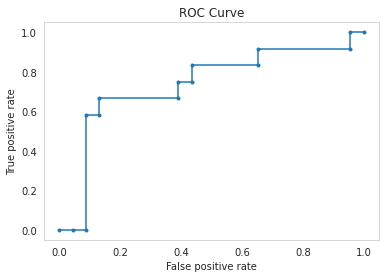

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
y_pred = modelBinary.predict(seq_test).ravel()
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(scoreBinaryTest2, y_pred)
auc_keras = round(auc(nn_fpr_keras, nn_tpr_keras),2)
label=auc_keras
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.grid(False)
import matplotlib.patches as mpatches
# red_patch = mpatches.Patch(label=label)
# plt.legend(handles=[red_patch],pl)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.')
plt.show()

## Precision- Recall- F1score

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# predict probabilities for test set
yhat_probs = modelBinary.predict(seq_test, verbose=0)
# predict crisp classes for test set
yhat_classes = (modelBinary.predict(seq_test) > 0.5).astype("int32")

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]


precision = precision_score(scoreBinaryTest2, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(scoreBinaryTest2, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(scoreBinaryTest2, yhat_classes)
print('F1 score: %f' % f1)

Precision: 0.700000
Recall: 0.583333
F1 score: 0.636364


# Models

## Binary Cross Entropy

In [ ]:

from sklearn.model_selection import train_test_split
model = keras.Sequential()
model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(tf.keras.layers.GRU(128,return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True)))
model.add(Dropout(0.4))
# model.add(Attention(return_sequences=True)) 
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(Dropout(0.25))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,mode="auto",
                              patience=3)

# BINARY CROSSENTROPY
modelBinary=model
modelBinary.add(Dense(1,activation='sigmoid'))


# # model.summary()
scoreBinary2 = train_df_final["PHQ8_Binary"].to_numpy()
scoreBinaryTest2=val_df["PHQ8_Binary"].to_numpy()
optimizer = tf.optimizers.Adam(learning_rate=0.004)
modelBinary.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
es_callback = EarlyStopping(monitor='val_loss', patience=10)

# RANDOM OVERSAMPLING
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
seq_testR, scoreBinaryTest2R = oversample.fit_resample(seq_test, scoreBinaryTest2)

# SPLIT VALIDATION DATA
seq_trainRSplitted, XValidation, scoreBinary2RSplitted, YValidation = train_test_split(seq_train,scoreBinary2,stratify=scoreBinary2,test_size=0.1) # before model building
seq_trainRSplitted, scoreBinary2RSplitted = oversample.fit_resample(seq_trainRSplitted, scoreBinary2RSplitted)
XValidation, YValidation = oversample.fit_resample(XValidation, YValidation)

# WITHOUT SPLITTED DATA
# seq_trainR, scoreBinary2R = oversample.fit_resample(seq_train, scoreBinary2)
# history = modelBinary.fit(seq_trainR, scoreBinary2R , validation_data=(seq_testR, scoreBinaryTest2R) ,batch_size=10,
#           epochs=15,callbacks=[reduce_lr,es_callback])

# WITH SPLITTED DATA
history = modelBinary.fit(seq_trainRSplitted, scoreBinary2RSplitted , validation_data=(XValidation, YValidation) ,batch_size=10,
          epochs=8,callbacks=[reduce_lr,es_callback])


print("Evaluate on test data")
results = modelBinary.evaluate(seq_testR, scoreBinaryTest2R, batch_size=2)
print("test loss, test acc:", results)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

Epoch 1/8
28/28 [==============================] - 23s 422ms/step - loss: 0.8555 - accuracy: 0.5326 - val_loss: 0.7511 - val_accuracy: 0.5000
Epoch 2/8
28/28 [==============================] - 10s 368ms/step - loss: 0.7194 - accuracy: 0.5254 - val_loss: 0.6734 - val_accuracy: 0.5000
Epoch 3/8
28/28 [==============================] - 10s 367ms/step - loss: 0.6468 - accuracy: 0.6522 - val_loss: 0.6070 - val_accuracy: 0.7188
Epoch 4/8
28/28 [==============================] - 10s 367ms/step - loss: 0.5230 - accuracy: 0.7464 - val_loss: 0.5728 - val_accuracy: 0.6562
Epoch 5/8
28/28 [==============================] - 10s 367ms/step - loss: 0.4685 - accuracy: 0.7971 - val_loss: 0.5321 - val_accuracy: 0.7812
Epoch 6/8
28/28 [==============================] - 10s 368ms/step - loss: 0.3728 - accuracy: 0.8623 - val_loss: 0.7816 - val_accuracy: 0.7188
Epoch 7/8
28/28 [==============================] - 10s 367ms/step - loss: 0.2044 - accuracy: 0.9457 - val_loss: 1.0488 - val_accuracy: 0.7500
Epoch 

In [ ]:
modelBinary.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1769, 300)         1538700   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 1769, 256)         330240    
_________________________________________________________________
dropout_25 (Dropout)         (None, 1769, 256)         0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 1769, 256)         296448    
_________________________________________________________________
dropout_26 (Dropout)         (None, 1769, 256)         0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 1769, 256)         296448    
_________________________________________________________________
dropout_27 (Dropout)         (None, 1769, 256)        

## Regression

In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = keras.Sequential()
from keras.regularizers import l2
model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))


model.add(Bidirectional(tf.keras.layers.GRU(256,return_sequences=True)))
# model.add(Dropout(0.2))
model.add(Bidirectional(tf.keras.layers.GRU(256,activation='tanh',return_sequences=True)))
# model.add(Dropout(0.2))
model.add(Bidirectional(tf.keras.layers.GRU(256,activation='tanh',return_sequences=True)))
# model.add(Dropout(0.2))
# model.add(Attention(return_sequences=True)) 
model.add(tf.keras.layers.GlobalMaxPooling1D())
# model.add(Dropout(0.1))
model.add(Dense(256,activation='relu'))
# model.add(Dropout(0.2))


# from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,mode="auto",
                              patience=3)

# Regression
modelRegression=model
modelRegression.add(Dense(1,activation='sigmoid'))
optimizer = tf.optimizers.Adam()
modelRegression.compile(loss='huber', optimizer=optimizer, metrics=['accuracy','mae'])
# scoreBinary3 = np.array(scorePhq8[0])
# scoreBinaryTest3 = np.array(scorePhq8Test[0] )
scoreBinary3 = train_df_final["PHQ8_Score"].to_numpy()
scoreBinaryTest3=val_df["PHQ8_Score"].to_numpy()



es_callback = EarlyStopping(monitor='val_loss', patience=10)

# RANDOM OVERSAMPLING
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
seq_testR, scoreBinaryTest2R = oversample.fit_resample(seq_test, scoreBinaryTest2)

# SPLIT VALIDATION DATA
seq_trainRSplitted, XValidation, scoreBinary2RSplitted, YValidation = train_test_split(seq_train,scoreBinary3,stratify=scoreBinary3,test_size=0.1) # before model building
seq_trainRSplitted, scoreBinary2RSplitted = oversample.fit_resample(seq_trainRSplitted, scoreBinary2RSplitted)
XValidation, YValidation = oversample.fit_resample(XValidation, YValidation)





# WITH SPLITTED DATA
history = modelRegression.fit(seq_trainRSplitted, scoreBinary2RSplitted , validation_data=(XValidation, YValidation) ,batch_size=10,
          epochs=8,callbacks=[reduce_lr,es_callback])


print("Evaluate on test data")
results = modelRegression.evaluate(seq_testR, scoreBinaryTest3, batch_size=2)
print("test loss, test acc:", results)

# es_callback = EarlyStopping(monitor='val_loss', patience=3)

# history = modelRegression.fit(seq_train, scoreBinary3 , batch_size=10,
#           epochs=10, 
#           validation_data=(seq_test, scoreBinaryTest3) 
            # )


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/8
22/22 [==============================] - 20s 600ms/step - loss: 6.1859 - accuracy: 0.0913 - mae: 6.6469 - val_loss: 4.7917 - val_accuracy: 0.0833 - val_mae: 5.2500
Epoch 2/8
22/22 [==============================] - 11s 483ms/step - loss: 6.1712 - accuracy: 0.0731 - mae: 6.6347 - val_loss: 4.7917 - val_accuracy: 0.0833 - val_mae: 5.2500
Epoch 3/8
22/22 [==============================] - 11s 484ms/step - loss: 6.1712 - accuracy: 0.0731 - mae: 6.6347 - val_loss: 4.7917 - val_accuracy: 0.0833 - val_mae: 5.2500
Epoch 4/8
22/22 [==============================] - 11s 484ms/step - loss: 6.1712 - accuracy: 0.0731 - mae: 6.6347 - val_loss: 4.7917 - val_accuracy: 0.0833 - val_mae: 5.2500
Epoch 5/8
20/22 [==========================>...] - ETA: 0s - loss: 6.0900 - accuracy: 0.0700 - mae: 6.5550

KeyboardInterrupt: ignored

## ΝΕURAL NETWORK WITH TWO OUTPUTS



In [ ]:
scoreBinary2 = train_df_final["PHQ8_Binary"].to_numpy()
scoreBinaryTest2=val_df["PHQ8_Binary"].to_numpy()
scoreBinary3 = train_df_final["PHQ8_Score"].to_numpy()
scoreBinaryTest3=val_df["PHQ8_Score"].to_numpy()
# Neural network with two outputs
import tensorflow as tf
data = tf.keras.layers.Input(shape = (seq_train.shape[1]))
embeddingData=tf.keras.layers.Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False)(data)
print(embeddingData)


bidirectionalData=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddingData)
dropout1=tf.keras.layers.Dropout(0.4)(bidirectionalData)
bidirectionalData2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(dropout1)
dropout2=tf.keras.layers.Dropout(0.4)(bidirectionalData2)
bidirectionalData3=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(dropout2)
dropout3=tf.keras.layers.Dropout(0.4)(bidirectionalData3)


bidirectionalT=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddingData)
dropoutT1=tf.keras.layers.Dropout(0.4)(bidirectionalT)
bidirectionalT2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(dropoutT1)
dropoutT2=tf.keras.layers.Dropout(0.4)(bidirectionalT2)
bidirectionalT3=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(dropoutT2)
dropoutT3=tf.keras.layers.Dropout(0.4)(bidirectionalT3)



pooling = tf.keras.layers.GlobalAveragePooling1D()(
    dropoutT3)
dropoutT4=tf.keras.layers.Dropout(0.25)(pooling)

denseLayer = tf.keras.layers.Dense(256)(dropoutT4)
dropoutLast=tf.keras.layers.Dropout(0.4)(denseLayer)
print(denseLayer)
# binaryOutput = tf.keras.layers.TimeDistributed(Dense(1, activation = 'sigmoid'),name="binary")(dropoutLast)
# phq8Output = tf.keras.layers.TimeDistributed(Dense(1, activation = 'sigmoid'),name="phq8")(dropoutLast)

binaryOutput = tf.keras.layers.Dense(1, activation = 'sigmoid',name="binary")(dropoutLast)
phq8Output = tf.keras.layers.Dense(1, activation = 'sigmoid',name="phq8")(dropoutLast)

lstm = tf.keras.Model(inputs = [data], outputs = [binaryOutput, phq8Output])

KerasTensor(type_spec=TensorSpec(shape=(None, 1746, 300), dtype=tf.float32, name=None), name='embedding_1/embedding_lookup/Identity_1:0', description="created by layer 'embedding_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='dense_1/BiasAdd:0', description="created by layer 'dense_1'")


In [ ]:
scoreBinaryTest2.shape

(34,)

In [ ]:

from keras import metrics
losses = {
	"binary": "binary_crossentropy",
	"phq8": tf.losses.Huber()
}
	# "phq8": tf.losses.Huber(),

# Complile our model
optimizer = tf.optimizers.Adam(learning_rate=0.0004)
lstm.compile(loss=losses, optimizer=optimizer ,metrics=['accuracy',tf.keras.metrics.MeanAbsolutePercentageError()
    ])
# Train our model
modelType="LSTM"
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,mode="auto",
                              patience=3)
# lstm.summary() 
history = lstm.fit(x=seq_train,y=[scoreBinary2,scoreBinary3], validation_data=(seq_test, [scoreBinaryTest2,scoreBinaryTest3] ) ,batch_size=12,
          epochs=20,callbacks=[reduce_lr])
# history = lstm.fit(x=seq_train,y=[scoreBinary2,scoreBinary3], validation_data=(seq_test, [scoreBinaryTest2,scoreBinaryTest3] ) ,batch_size=1,
#           epochs=10)


# NOT READYYY


# RANDOM OVERSAMPLING
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
seq_testR, scoreBinaryTest2R = oversample.fit_resample(seq_test, scoreBinaryTest2)

# SPLIT VALIDATION DATA
seq_trainRSplitted, XValidation, scoreBinary2RSplitted, YValidation = train_test_split(seq_train,scoreBinary2,stratify=scoreBinary2,test_size=0.1) # before model building
seq_trainRSplitted, scoreBinary2RSplitted = oversample.fit_resample(seq_trainRSplitted, scoreBinary2RSplitted)
XValidation, YValidation = oversample.fit_resample(XValidation, YValidation)

# WITHOUT SPLITTED DATA
# seq_trainR, scoreBinary2R = oversample.fit_resample(seq_train, scoreBinary2)
# history = modelBinary.fit(seq_trainR, scoreBinary2R , validation_data=(seq_testR, scoreBinaryTest2R) ,batch_size=10,
#           epochs=15,callbacks=[reduce_lr,es_callback])

# WITH SPLITTED DATA
history = lstm.fit(seq_trainRSplitted, scoreBinary2RSplitted , validation_data=(XValidation, YValidation) ,batch_size=15,
          epochs=8,callbacks=[reduce_lr,es_callback])


print("Evaluate on test data")
results = lstm.evaluate(seq_testR, scoreBinaryTest2R, batch_size=2)
print("test loss, test acc:", results)

Epoch 1/20
18/18 [==============================] - 38s 2s/step - loss: 6.0398 - binary_loss: 0.6177 - phq8_loss: 5.4222 - binary_accuracy: 0.7103 - binary_mean_absolute_percentage_error: 222933600.0000 - phq8_accuracy: 0.0981 - phq8_mean_absolute_percentage_error: 117753144.0000 - val_loss: 6.7974 - val_binary_loss: 0.7315 - val_phq8_loss: 6.0659 - val_binary_accuracy: 0.6765 - val_binary_mean_absolute_percentage_error: 164995344.0000 - val_phq8_accuracy: 0.0588 - val_phq8_mean_absolute_percentage_error: 145750960.0000
Epoch 2/20
18/18 [==============================] - 25s 1s/step - loss: 5.9205 - binary_loss: 0.6543 - phq8_loss: 5.2662 - binary_accuracy: 0.7056 - binary_mean_absolute_percentage_error: 206989440.0000 - phq8_accuracy: 0.0841 - phq8_mean_absolute_percentage_error: 149015600.0000 - val_loss: 6.7609 - val_binary_loss: 0.7001 - val_phq8_loss: 6.0608 - val_binary_accuracy: 0.6765 - val_binary_mean_absolute_percentage_error: 178813424.0000 - val_phq8_accuracy: 0.0588 - val_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


NameError: ignored

In [ ]:
# BEST ONE
val_binary_loss: 0.5891 - val_phq8_loss: 6.0691 - val_binary_accuracy: 0.7353 

NameError: ignored